# TP6 : PAC-Bayes

Hedi Hadiji, Theoretical principles of Deep Learning, 24/25, CS-UPSACLAY

The goal of this notebook is to illustrate the optimization of PAC-Bayes bounds on some MNIST task. 

In [ ]:
import torch

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import copy
from IPython.display import clear_output

clear_output()

/Users/hadiji/anaconda3/envs/dl_tutorial/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/hadiji/anaconda3/envs/dl_tutorial/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/hadiji/anaconda3/envs/dl_tutorial/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E6933B13-F4A0-3821-8466-03F22A3B3739> /Users/hadiji/anaconda3/envs/dl_tutorial/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# The data

In [2]:
n = 2000  # number of training points that we keep
c1, c2 = 3, 6  # subclasses that are kept, make sure that c1 < c2

batch_size = 32  # training batch size

classes = (
    "T-shirt/Top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
)

# Define a sequence of operations that will be performed to all training
# images before use the 'ToTensor()' function sets the image in tensor
# object and puts the values of every pixel between 0 and 1 the
# 'Normalize' performs the dataset to a given mean and variance
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Creates an object to load the images. We use FashionMNIST as a
# substitute for MNIST because binary classification on subclasses of
# MNIST is too easy.

trainset = datasets.FashionMNIST(
    "../data", train=True, download=True, transform=transform
)

r = torch.arange(len(trainset))

# Build a training set that only contains images with classes c1 and c2,
#  with n / 2 images from each label.

if c1 != 0:
    trainset.targets[trainset.targets == 0] = -1
    trainset.targets[trainset.targets == c1] = 0

if c2 != 1:
    trainset.targets[trainset.targets == 1] = -1
    trainset.targets[trainset.targets == c2] = 1

idxc1 = torch.as_tensor(trainset.targets) == 0
x1 = np.where(np.cumsum(idxc1) == (n / 2))[0][0]
idxc1 = idxc1 & (r <= x1)

idxc2 = torch.as_tensor(trainset.targets) == 1
x2 = np.where(np.cumsum(idxc2) == (n / 2))[0][0]
idxc2 = idxc2 & (r <= x2)

idx = idxc1 + idxc2
dset_train = torch.utils.data.dataset.Subset(trainset, np.where(idx == 1)[0])


print(f"Number of training points : {len(dset_train)}")
trainloader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size)

# Build the corresponding test set

testset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)
clear_output()

if c1 != 0:
    testset.targets[testset.targets == 0] = -1
    testset.targets[testset.targets == c1] = 0

if c2 != 1:
    testset.targets[testset.targets == 1] = -1
    testset.targets[testset.targets == c2] = 1

idx = torch.as_tensor(testset.targets) == 0
idx += torch.as_tensor(testset.targets) == 1
dset_test = torch.utils.data.dataset.Subset(testset, np.where(idx == 1)[0])


testloader = torch.utils.data.DataLoader(dset_test)

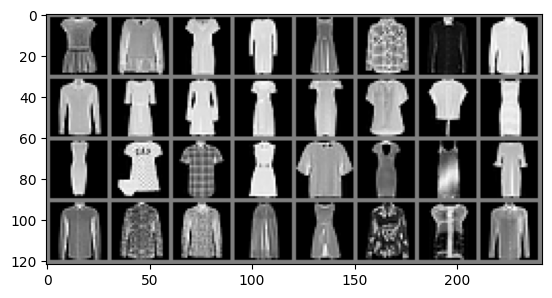

In [3]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get batch_size random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# A neural network

Fully connected 1-hidden layer neural network. Flattens the image and treats it as a vector. 



In [25]:
m = 20


class MLPDeep(nn.Module):
    def __init__(
        self,
    ):
        super().__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(28 * 28, m)
        self.l2 = nn.Linear(m, m)
        self.l3 = nn.Linear(m, m)
        self.lout = nn.Linear(m, 2)

        # Store the initial value for the bound optimization
        with torch.no_grad():
            self.w0 = copy.deepcopy(self.state_dict())

        self.total_parameters = sum(param.numel() for param in self.parameters())

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.lout(x)
        return x


net = MLPDeep()

print("Number of parameters :", net.total_parameters)


Number of parameters : 16582


## The training function

We train the network with the square loss to predict the class. The labels are normalized to be between $0$ and $1$.

In [26]:
def train(net, trainloader, N_passes=1, lr=0.01):
    optimizer = optim.SGD(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    losses = []
    i = 0

    for _ in range(N_passes):
        for inputs, labels in trainloader:
            i += 1
            optimizer.zero_grad()

            # print(inputs.shape)
            # print(torch.linalg.vector_norm(inputs, dim=(1, 2, 3)))

            outputs = net(inputs)
            target = labels
            loss = criterion(outputs, target)

            loss.backward()
            optimizer.step()

            losses.append(loss.detach().numpy())

    print(f"Number of gradient steps {i}")

    return losses

Batch size :  32
Number of gradient steps 6300


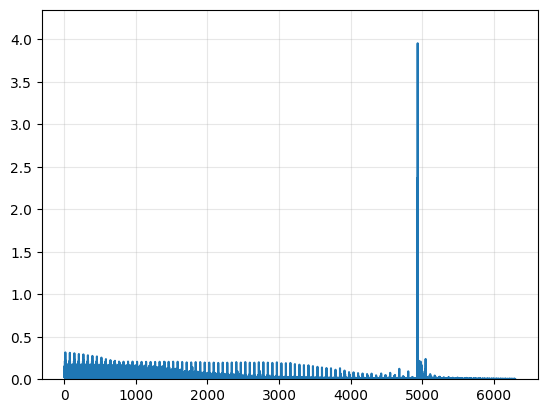

In [29]:
print("Batch size : ", batch_size)

losses = train(net, trainloader, N_passes=100, lr=0.01)

torch.save(net.state_dict(), "models/trained_net.pt")

plt.ylim(0, 1.1 * np.max(losses))
plt.plot(losses)
plt.grid(alpha=0.3)

### Checking the training values


In [30]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in trainloader:
        outputs = net(images)
        predicted = torch.argmax(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum()

print(
    f"Accuracy of the network on the {total} train images: {100 * correct // total} %"
)

Accuracy of the network on the 2000 train images: 100 %


# Test loss

In [32]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testloader:
        outputs = net(images)
        predicted = torch.argmax(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum()

print(f"Accuracy of the network on the {total} test images: {100 * correct // total} %")

Accuracy of the network on the 2000 test images: 92 %


# PAC Bayes bound optimization

In [33]:
def kl(q, p):
    return q * np.log(q / p) + (1 - q) * np.log((1 - q) / (1 - p))


def klprime(q, p):
    return -q / p + (1 - q) / (1 - p)


def klinvert(q, c, k=10):
    if q == 0.0:
        return -np.log(1 - np.exp(-c))
    r = q + np.sqrt(c / 2)
    for _ in range(k):
        if r >= 1:
            return 1.0
        else:
            r = r - (kl(q, r) - c) / klprime(q, r)
    return r

In [34]:
class PACBayesBound(nn.Module):
    """
    This object keeps track of everything that is in the pac bayes upper bound.
        - the prior parameter
        - the posterior parameters
    """

    def __init__(self, net, nsamples, delta=0.02, deltaprime=0.01):
        super().__init__()

        ### Initialize the posterior means
        self.w_post = net

        ### Initialize the posterior variances
        self.sigma_post = copy.deepcopy(net)
        norm = sum([torch.sum(param**2) for param in self.w_post.parameters()])
        # print(norm)
        for param in self.sigma_post.parameters():
            param.data = torch.sqrt(norm) * torch.ones_like(param.data)

        ### Initalize the prior
        self.lambda_max = torch.tensor([10])
        self.alpha = torch.tensor([0.5])
        self.sigmaPrior = torch.nn.Parameter(torch.tensor([0.09]), requires_grad=True)

        ### Other parameters
        self.d = net.total_parameters
        self.delta = torch.tensor([delta])
        self.deltaprime = torch.tensor([deltaprime])

        self.nsamples = nsamples

        self.final_bound_value = None

    def KL_g(self):
        l = self.sigmaPrior
        norm, dw, logterm = 0, 0, 0

        for param_s, param_w, param_w0 in zip(
            self.sigma_post.parameters(),
            self.w_post.parameters(),
            self.w_post.w0.values(),
        ):
            # print('w0', param_w0.shape)
            # print('w', param_w.shape)
            # print('s', param_s.shape)

            norm += torch.sum(param_s**2) / (2 * l**2)
            dw += torch.sum((param_w - param_w0) ** 2) / (2 * l**2)
            logterm += torch.sum(torch.log((l / param_s) ** 2) - 1) / 2

        return norm + dw + logterm

    def meta_prior_cost(self):
        first = np.pi**2 / 6
        second = (
            torch.log((self.sigmaPrior / self.lambda_max) ** 2)
            / (2 * torch.log(self.alpha))
        ) ** 2
        # print(second)
        return torch.log(first * second)

    def full_KL_bound(self):
        KL_g = self.KL_g()
        conf = torch.log(2 * torch.sqrt(self.nsamples / self.delta))
        metaprior = self.meta_prior_cost()
        return (KL_g + conf + metaprior) / self.nsamples

    def estimate_sample_error(self, dset_train, m):
        """
        Samples m networks according to the current posterior, evaluates them on the training data, and returns the average
        """

        trainloader = torch.utils.data.DataLoader(dset_train, batch_size=self.nsamples)
        corrects = []
        with torch.no_grad():
            for _ in range(m):
                sample_net = copy.deepcopy(bound.w_post)
                for param, param_s, param_w in zip(
                    sample_net.parameters(),
                    self.sigma_post.parameters(),
                    self.w_post.parameters(),
                ):
                    param = param_w + param_s * torch.normal(torch.zeros_like(param), 1)

                correct = 0
                total = 0
                for images, labels in trainloader:
                    outputs = sample_net(images)
                    predicted = torch.argmax(outputs, 1)

                    total += labels.size(0)
                    correct += (predicted == labels).sum()
                corrects.append(correct / total)

        self.error_estimate = 1 - np.mean(corrects)
        print(
            f"Estimated average posterior error on the training set {self.error_estimate}"
        )

    def final_bound(self, m):
        """
        TODO: put the real prior from the grid
        """

        half_bound = klinvert(self.error_estimate, torch.log(1 / self.deltaprime) / m)
        with torch.no_grad():
            full_bound = klinvert(half_bound, self.full_KL_bound())

        self.final_bound_value = full_bound

        success_prob = (1 - self.delta - self.deltaprime).detach()
        print(
            f"With probability at least {float(success_prob)},"
            + f"the average loss under the posterior is less than {self.final_bound_value}"
        )
        return self.final_bound_value


net = MLPDeep()
net.load_state_dict(torch.load("models/trained_net.pt"))
bound = PACBayesBound(net, n)

In [35]:
def optimize_bound(bound, dset_train, N_passes=2, lr=0.01):
    trainloader = torch.utils.data.DataLoader(dset_train, batch_size=bound.nsamples)

    all_parameters = (
        list(bound.w_post.parameters())
        + list(bound.sigma_post.parameters())
        + [bound.sigmaPrior]
    )
    optimizer = optim.SGD(all_parameters, lr=lr)
    criterion = nn.CrossEntropyLoss()

    losses = []
    i = 0

    for _ in range(N_passes):
        for inputs, labels in trainloader:
            i += 1
            optimizer.zero_grad()

            perturbed_net = copy.deepcopy(bound.w_post)
            for param, param_s, param_w in zip(
                perturbed_net.parameters(),
                bound.sigma_post.parameters(),
                bound.w_post.parameters(),
            ):
                param = param_w + param_s * torch.normal(torch.zeros_like(param), 1)

            outputs = perturbed_net(inputs)
            target = labels
            loss = criterion(outputs, target) + torch.sqrt(bound.full_KL_bound() / 2)

            loss.backward()
            optimizer.step()

            losses.append(loss.detach().numpy())

    print(f"Number of gradient steps {i}")
    print(f"First optimized bound value {losses[0]}")
    print(f"Last optimized bound value {losses[-1]}")

    return losses


Number of gradient steps 50
First optimized bound value [0.0456464]
Last optimized bound value [0.04540043]


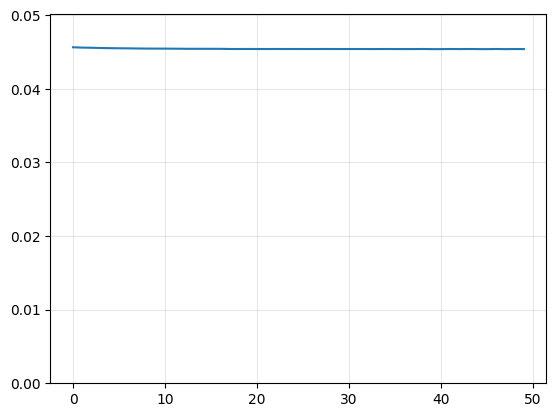

In [42]:
losses = optimize_bound(bound, dset_train, N_passes=50, lr=0.03)

plt.ylim(0, 1.1 * np.max(losses))
plt.plot(losses)
plt.grid(alpha=0.3)

In [43]:
m = 50
bound.estimate_sample_error(dset_train, m)

Estimated average posterior error on the training set 0.0


In [53]:
final_bound = bound.final_bound(
    m
)  # cheat a bit by faking a large m to see if there is a chance that the bound is good

print(float(bound.sigmaPrior.detach()))
print(float(bound.KL_g().detach()))
print(np.sqrt(float(bound.KL_g().detach() / n)))

With probability at least 0.9700000286102295,the average loss under the posterior is less than 1
6.270560264587402
0.775390625
0.019689980369098897


**Interesting questions:**
- evaluate the posterior on the test set
- find ways to examine and interpret the prior and posterior 
- investigate the flat minimum hypothesis
- repeat the experiment with random labels

# Pinsker's inequality, etc. 

In [15]:
def kl(q, p):
    return q * np.log(q / p) + (1 - q) * np.log((1 - q) / (1 - p))


def dtv(q, p):
    return 2 * (q - p) ** 2

/var/folders/cm/7280s6y15mn539f8rdw75s400000gp/T/ipykernel_64520/3689498933.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return q * np.log(q / p) + (1 - q) * np.log((1 - q) / (1 - p))


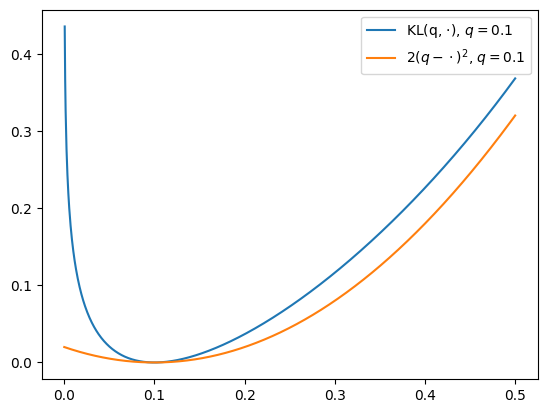

In [16]:
q = 0.1

ps = np.linspace(0, 0.5, 1000)

klvals = [kl(q, p) for p in ps]
tvvals = [dtv(q, p) for p in ps]

plt.plot(ps, klvals, label=rf"KL(q, $\cdot$), $q = {q}$")
plt.plot(ps, tvvals, label=rf"$2(q - \cdot)^2$, $q = {q}$")

plt.legend()
plt.show()

/var/folders/cm/7280s6y15mn539f8rdw75s400000gp/T/ipykernel_64520/4088222821.py:13: RuntimeWarning: invalid value encountered in scalar divide
  r = r - (kl(q, r) - c) / klprime(q, r)


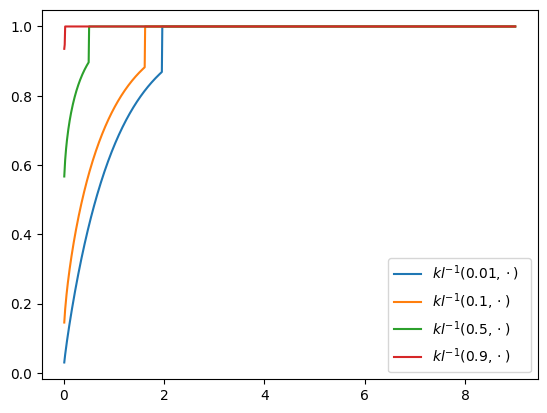

In [ ]:
def klprime(q, p):
    return -q / p + (1 - q) / (1 - p)


def klinvert(q, c, k=10):
    if q == 0.0:
        return -np.log(1 - np.exp(-c))
    r = q + np.sqrt(c / 2)
    for _ in range(k):
        if r >= 1:
            return 1
        else:
            r = r - (kl(q, r) - c) / klprime(q, r)
    return r


### Testing the inversion
q = 0.499
cs = np.linspace(0.001, 0.5)
kls = []
us = []

# for c in cs:
#     p = klinvert(q, c)
#     kls.append(kl(q , p))

# plt.title(f"$kl(q, kl^{{-1}}(q, c)) = c$")
# plt.plot(cs, kls - cs)

# plt.show()

# qs = np.linspace(0, 1, 1000)
# for c in [.01, .1, .2]:
#     plt.plot(qs, [klinvert(q, c) for q in qs], label=fr'$kl^{{-1}}(\cdot, {c})$  ')
# plt.legend()
# plt.show()


cs = np.linspace(0, 9, 1000)
for q in [0.01, 0.1, 0.5, 0.9]:
    plt.plot(cs, [klinvert(q, c) for c in cs], label=rf"$kl^{{-1}}({q}, \cdot)$  ")
plt.legend()
plt.show()